# Machine Learning with Yellowbrick Visualizations
Author: Zach Fernandes
Date 6/11/18
Desc: This does some more machine learning with the med student data by reclassifying the data. (The target will now include low pass grades in addition to fails)

## Part One: File Setup

### Import Data and Plotting Packages

In [1]:
# Everyday Packages #
import numpy    as np
import pandas   as pd
import re
import os
import sys
import seaborn as sns 
import yellowbrick as yb
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

# Sklearn Packages
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Imputer, FunctionTransformer
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_score




## YellowBrick Packages ##
from yellowbrick.classifier import ClassificationReport

### Import Custom Modules

In [2]:
wd = os.getcwd()
mod_dir     = wd + '/../custom_modules/'
sys.path.insert(0, mod_dir)
import cleaning_helpers as helpers

### Change those annoying Pandas Defaults

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

## Part Two: Import and Transform Data

### Read in the Data

In [6]:
path = wd + '/../../../med_school_data/output/'
file_name = 'final_data.csv'

def load_data(csv, path):
	df = pd.read_csv(path + csv)
	return df

data = load_data(file_name, path)
data.m1_fall.value_counts()


2009    203
2011    197
2014    194
2013    194
2012    192
2010    191
2015    181
Name: m1_fall, dtype: int64

In [18]:

year_counts = pd.DataFrame(data.m1_fall.value_counts()).reset_index()
year_counts.rename(columns = {'index':'Year Accepted', 
                    'm1_fall':'Total Students' }, inplace = True)
#year_counts

data.head()

,m1_fall,mcat_zscore,mcat_total_attempts,bachelor_1,bachelor_2,bachelor_3,master_1,master_2,master_3,associate_1,associate_2,biochem_likelyhood,gem_indicator,race,gender,m1f_limbs,m1f_metabolism_nutrition_and_endo,m1f_molecular_and_cell_physiology,m1f_molecular_and_human_genetics,m1s_cardio_pulmonary,m1s_ebm_and_population_health,m1s_gastrointestinal,m1s_head_neck_and_special_senses,m1s_patients_populations_and_policy,m1s_physical_diagnosis_i,m1s_renal_and_electrolytes,m1s_sexual_dev__and_reproduction,m2s_clinical_skills_primer,m2s_evidence_based_medicine_ii,m2s_health_care_ethics,m2s_human_sexuality,m2s_lab_medicine_pblm_solving_case,m2s_microbiology_and_immunology,m2s_pathology,m2s_pharmacology,m2s_physical_diagnosis_ii,m2s_psychiatry,step1_z_score,step1_pass_indicator,step1_total_attempts,target_indicator,double_bachelor,master_degree,double_master,associate_degree,science_undergrad,science_master,bachelors_num,science_bachelors_num,masters_num,science_masters_num,GPA,step1_rank,step1_total_students,step1_percentile,step1_low_score,danger_student
0,2009,2.505529,1.0,Science,missing,missing,Science,missing,missing,missing,missing,4.0,0.0,White,M,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,1.0,4.0,4.0,3.0,2.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,3.0,2.178880,1.0,1.0,0,0,1,0,0,1,1,1.0,1.0,1,1,3.380952,203.0,203.0,1.000000,0,0
1,2009,-1.407328,2.0,Science,missing,missing,Science,missing,missing,Science,missing,1.0,1.0,Black or African American,F,2.0,3.0,2.0,2.0,4.0,2.0,4.0,2.0,3.0,1.0,4.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,-0.836599,1.0,1.0,0,0,1,0,1,1,1,1.0,1.0,1,1,2.333333,28.0,203.0,0.137931,1,1
2,2009,0.745614,1.0,Arts,missing,missing,missing,missing,missing,missing,missing,3.0,0.0,White,M,2.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,2.0,1.0,2.0,0.747805,1.0,1.0,0,0,0,0,0,0,0,1.0,1.0,0,0,2.428571,156.5,203.0,0.770936,0,0
3,2009,0.149933,1.0,Science,missing,missing,missing,missing,missing,missing,missing,4.0,0.0,White,M,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,3.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,-0.121062,1.0,1.0,0,0,0,0,0,1,0,1.0,1.0,0,0,2.714286,75.0,203.0,0.369458,0,0
4,2009,-0.973841,1.0,Science,missing,missing,missing,missing,missing,missing,missing,4.0,1.0,Asian,F,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,-1.501027,1.0,1.0,0,0,0,0,0,1,0,1.0,1.0,0,0,2.055556,8.0,203.0,0.039409,1,1


### Make Column Lists
For now I think we'll disregard any courses taken in the second semester, as the main motivation behind this project is to identify first year students that might be at risk of failure

In [7]:

courses = ['m1f_limbs', 'm1f_metabolism_nutrition_and_endo', 
        'm1f_molecular_and_cell_physiology',
        'm1f_molecular_and_human_genetics','m1s_cardio_pulmonary', 
        'm1s_ebm_and_population_health','m1s_gastrointestinal', 
        'm1s_head_neck_and_special_senses', 'm1s_patients_populations_and_policy',
        'm1s_physical_diagnosis_i', 'm1s_renal_and_electrolytes', 
        'm1s_sexual_dev__and_reproduction']

categorical = ['bachelor_1', 'bachelor_2', 'bachelor_3',
               'master_1', 'master_2', 'master_3', 'associate_1',
               'associate_2', 'race', 'gender']

indicators = ['gem_indicator', 'double_bachelor', 'double_master']

continuous = ['mcat_zscore']

discontinuous = ['mcat_total_attempts', 'biochem_likelyhood']


target_elements = ['danger_student']

### Subset the Data
Select only the columns that we know we are going to use

In [8]:
train = data[courses + categorical + indicators + continuous + discontinuous]

X = train
y = data[target_elements]

### Transformer 1: Create Dummies
I know, I know, there's one hot encoder. But I'm not a big fan of it. I'd rather create a custom transformer that uses pandas get dummies. 

In [9]:
class MakeDummies(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
            
    def fit(self, data, target=None):
        if self.columns is None:
            self.columns = data.columns 
        return self
    
    def transform(self, data):
        output = data.copy()
        for col in self.columns:
            output = pd.get_dummies(data = output, columns = [col])
        return output

### Start the Pipeline


In [10]:
def visual_model_selection(X, y, model):
    
    stringNum  = MakeDummies(columns = categorical)
    X = stringNum.fit_transform(train)
    
    #model = Pipeline([
    #     ('one_hot_encoding', MakeDummies(categorical)),
    #     ('estimator', estimator)
    #])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    visualizer = ClassificationReport(model, classes=['Not At Risk', 'At risk'])
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.poof()

### Call the models

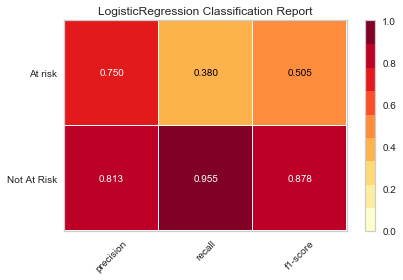

In [11]:
visual_model_selection(X, y, LogisticRegression())

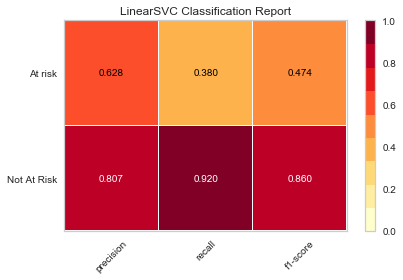

In [12]:
visual_model_selection(X, y, LinearSVC())

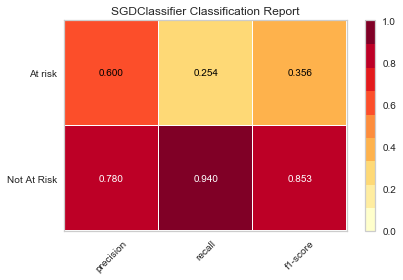

In [13]:
visual_model_selection(X, y, SGDClassifier())

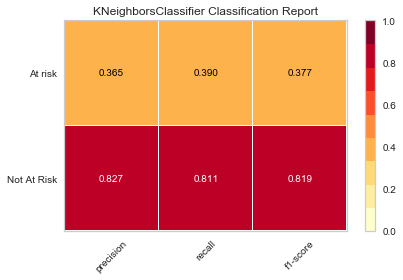

In [14]:
visual_model_selection(X, y, KNeighborsClassifier())

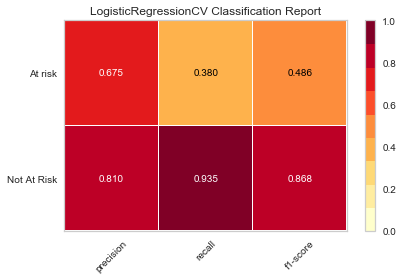

In [15]:
visual_model_selection(X, y, LogisticRegressionCV())


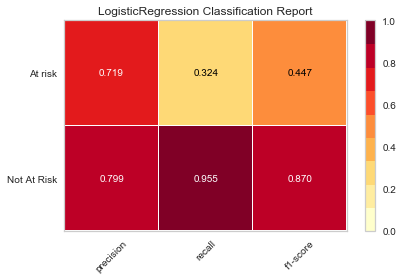

In [16]:
visual_model_selection(X, y, LogisticRegression())


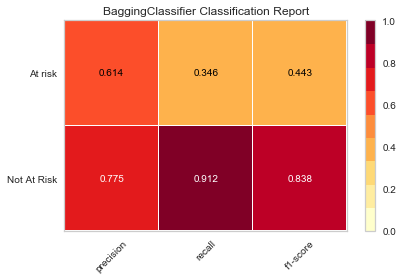

In [17]:
visual_model_selection(X, y, BaggingClassifier())


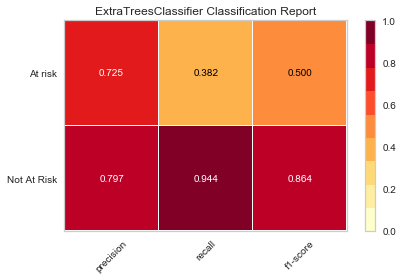

In [18]:
visual_model_selection(X, y, ExtraTreesClassifier())


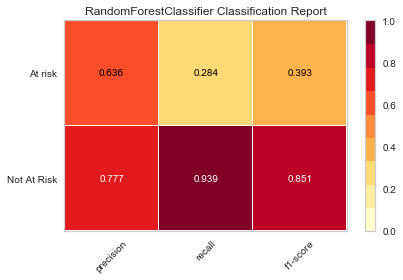

In [19]:
visual_model_selection(X, y, RandomForestClassifier())


### Well this is quite interesting:
Some models seem to be performing OK at best. Though, the one issue I have with this is that there is definitely a class imbalance, and not that many observations. So one test / train can be pretty wildly different from another.

### Let's dial up the power and run a bunch of iterations of train test split

In [20]:
#Label Encode the Categorical NAs
stringNum  = MakeDummies(columns = categorical)
X = stringNum.fit_transform(train)

sc = StandardScaler()


#### Function 1: Cross Validate

In [21]:
def ModelCrossVal(X, y, model):

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)
    fitted_model = model.fit(X_train, y_train)

    fitted_model.score(X_test, y_test)
    expected   = y_test
    predicted  = fitted_model.predict(X_test)

    classificationReport = classification_report(expected, predicted, target_names=["Not At Risk","At Risk"])
    scores = [recall_score(expected, predicted), precision_score(expected, predicted)]
    return scores

#### Function 2: Find Average Recall and Precision

In [22]:
def AvgRecall(X, y, n, model):
    x = 1
    recall_list = []
    presci_list = []
    while x <= n:
        scores = ModelCrossVal(X,y, model)
        recall_list.append(scores[0])
        presci_list.append(scores[1])
        x += 1
    recall    = round(np.mean(recall_list), 2)
    precision = round(np.mean(presci_list), 2) 
    return({'Recall' : recall, 'Precision' : precision})

#### Function 3: Loop through the models and produce a combined report

In [23]:
def LoopModels(X, y, models, n):
    stats = {}
    for key in models.keys():
        stats[key] = AvgRecall(X, y, n, models[key])
    stats_df = pd.DataFrame.from_dict(stats)
    return stats_df

#### Define the Models

In [24]:
ml_models = {'Linear SVC' : LinearSVC(), 
          'SVC'        : SVC(),
          'SGD'        : SGDClassifier(),
          'KNeighbors' : KNeighborsClassifier(),
          'Log. Reg.'  : LogisticRegression(),
          'Bagging'    : BaggingClassifier(),
          'Ex. Trees'  : ExtraTreesClassifier(),
          'RF'         : RandomForestClassifier()
         }

In [88]:
print('Running each model 100 times and printing an average recall score')
LoopModels(X, y, models, 100)

Running each model 100 times and printing an average recall score


,Bagging,Ex. Trees,KNeighbors,Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.54,0.53,0.50,0.57,0.57,0.56,0.57,0.73
Recall,0.34,0.30,0.39,0.31,0.37,0.32,0.49,0.18


### Interesting:
It looks like RF and Bagging weren't that good after all. Logistic Regression and SGD seem to be performing better now. 

### Using Different Features
 It would be great if we could find a way to tune this model to get better results. Oh wait, we can using feature selection. Please check out the YB Feature Selection notebook that I put together. I'll now use that insight to try and get a combination of features to boost this model. Below are the variables we found to be most important when doing feature analysis

In [25]:
vars_to_keep = courses + ['gender_M', 'race_Asian', 'master_1_Science', 
                               'master_1_missing', 'bachelor_1_Science',
                               'bachelor_2_Science', 'mcat_total_attempts', 'mcat_zscore' ,
                               'double_bachelor', 'biochem_likelyhood', 'race_White',
                            'gem_indicator', 'bachelor_2_missing', 'race_Black or African American']

#### Best Vars as indicated by the 1D Ranker from YB

In [135]:
X_new = sc.fit_transform(X[vars_to_keep])
y_new = y

In [136]:
def LoopModels(X, y, models, n):
    stats = {}
    for key in models.keys():
        stats[key] = AvgRecall(X, y, n, models[key])
    stats_df = pd.DataFrame.from_dict(stats)
    return stats_df
    

#### With Standard Scaler

In [139]:
LoopModels(X_new, y_new, ml_models, n = 1000)

,Bagging,Ex. Trees,KNeighbors,Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.53,0.54,0.49,0.59,0.57,0.55,0.44,0.63
Recall,0.35,0.33,0.38,0.31,0.37,0.32,0.43,0.29


#### Without Standard Scaler

In [140]:
LoopModels(X[vars_to_keep], y_new, ml_models, n = 1000)

,Bagging,Ex. Trees,KNeighbors,Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.53,0.54,0.51,0.60,0.59,0.55,0.61,0.68
Recall,0.35,0.33,0.41,0.31,0.34,0.32,0.41,0.24


#### Didn't help as much as we'd like. Let's just picking the most important courses

In [115]:
courses_refined = ['m1s_renal_and_electrolytes',
                   'm1f_metabolism_nutrition_and_endo',
                   'm1s_patients_populations_and_policy']

vars_to_keep = courses_refined + ['gender_M', 'race_Asian', 'master_1_Science', 
                               'master_1_missing', 'bachelor_1_Science', 'mcat_zscore',
                               'bachelor_2_Science', 'mcat_total_attempts', 
                               'double_bachelor', 'biochem_likelyhood', 'race_White',
                               'gem_indicator', 'bachelor_2_missing']

X_new = X[vars_to_keep]
y_new = y


In [116]:
LoopModels(X_new, y_new, ml_models, n = 100)

,Bagging,Ex. Trees,KNeighbors,Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.49,0.45,0.51,0.62,0.61,0.49,0.57,0.73
Recall,0.33,0.33,0.35,0.24,0.29,0.30,0.41,0.16


#### Still not working well at all. Does a straight sum accross courses work better

In [25]:
X['course_total'] = X[['m1f_limbs']]*0
for c in courses:
    X['course_total'] = X['course_total'] + X[c]

In [26]:
vars_to_keep = ['course_total'] + ['gender_M', 'race_Asian', 'master_1_Science', 
                               'master_1_missing', 'bachelor_1_Science',
                               'bachelor_2_Science', 'mcat_total_attempts', 
                               'double_bachelor', 'biochem_likelyhood', 'race_White', 'mcat_zscore',
                               'gem_indicator', 'bachelor_2_missing']
X_new = X[vars_to_keep]
y_new = y

In [121]:
LoopModels(X_new, y_new, ml_models, n = 100)

,Bagging,Ex. Trees,KNeighbors,Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.47,0.45,0.49,0.63,0.62,0.49,0.65,0.65
Recall,0.34,0.31,0.37,0.37,0.31,0.32,0.36,0.26


### This Sort of Stinks, but let's see if Hyperparameter tuning will help

In [58]:
weight = {0:1.,1:3}

ml_models = {'Linear SVC'  : LinearSVC(class_weight = weight), 
          'SVC'            : SVC(class_weight = weight),
          'SGD'            : SGDClassifier(class_weight = weight),
          'KNeighbors (4)' : KNeighborsClassifier(4),
          'Log. Reg.'      : LogisticRegression(class_weight = weight),
          'Bagging'        : BaggingClassifier(),
          'Ex. Trees'      : ExtraTreesClassifier(class_weight = weight),
          'RF'             : RandomForestClassifier(class_weight = weight)
         }





In [59]:
LoopModels(X[vars_to_keep], y, ml_models, n = 10)

,Bagging,Ex. Trees,KNeighbors (4),Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.47,0.46,0.52,0.50,0.45,0.46,0.39,0.44
Recall,0.32,0.32,0.24,0.52,0.77,0.30,0.75,0.80


In [60]:
LoopModels(X[['mcat_zscore']], y, ml_models, n = 10)

,Bagging,Ex. Trees,KNeighbors (4),Linear SVC,Log. Reg.,RF,SGD,SVC
Precision,0.46,0.31,0.42,0.38,0.36,0.35,0.31,0.43
Recall,0.19,0.47,0.14,0.54,0.54,0.49,0.45,0.45
